In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from scipy import stats
from scipy.stats.contingency import association

from sklearn.preprocessing import (
    LabelEncoder, 
    PowerTransformer, 
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    PolynomialFeatures
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest, mutual_info_classif

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    fbeta_score,
    roc_auc_score, 
    average_precision_score,
    confusion_matrix, 
    classification_report, 
    ConfusionMatrixDisplay, 
    RocCurveDisplay, 
    precision_recall_curve,
)

from yellowbrick.model_selection import (
    ValidationCurve,
    LearningCurve
)

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

from loguru import logger
from omegaconf import OmegaConf

pd.set_option('display.max_columns', None)
pd.options.plotting.backend = 'matplotlib'
warnings.filterwarnings('ignore')

In [2]:
def pipe_logger(df, addon_msg=''):
    if addon_msg != '':
        logger.info(addon_msg)
    logger.info(f"Shape of DataFrame: {df.shape[0]} x {df.shape[1]}")
    return df

In [3]:
hotel = pd.read_csv('../../data/raw/hotel_reservations.csv')
hotel

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


In [5]:
(hotel
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [6]:
(hotel
 .describe()
)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [7]:
(hotel
 ['booking_status']
 .value_counts(normalize=True, dropna=False))

booking_status
Not_Canceled    0.672364
Canceled        0.327636
Name: proportion, dtype: float64

In [8]:
def tweak_hotel(df: pd.DataFrame) -> pd.DataFrame:
    
    leap_year_error = (df
                       .loc[(df['arrival_year'] == 2018) & (df['arrival_month'] == 2) & (df['arrival_date'] == 29)]
                       .index)
    return (df
            .pipe(pipe_logger)
            .astype({**{k: 'int8' 
                        for k in ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests']},
                     **{k: 'int16'
                        for k in ['lead_time']},
                     **{k: 'category'
                        for k in ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type',]},
                     **{k: 'str'
                        for k in ['arrival_date', 'arrival_month', 'arrival_year']},
                     'avg_price_per_room': 'float16'})
            .drop(columns=['Booking_ID'])
            .drop(leap_year_error)
            .pipe(pipe_logger, "After dropping leap year error...")
            )

In [9]:
tweaked_hotel = tweak_hotel(hotel)
tweaked_hotel

2024-03-25 22:20:36.602 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 36275 x 19
2024-03-25 22:20:36.625 | INFO     | __main__:pipe_logger:3 - After dropping leap year error...
2024-03-25 22:20:36.626 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 36238 x 18


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.0000,0,Not_Canceled
1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.6875,1,Not_Canceled
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.0000,0,Canceled
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.0000,0,Canceled
4,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.5000,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.7500,1,Not_Canceled
36271,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.9375,2,Canceled
36272,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.3750,2,Not_Canceled
36273,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.5000,0,Canceled


In [10]:
X = tweaked_hotel.drop(columns=['booking_status'])
y = tweaked_hotel['booking_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
label_encoder = LabelEncoder()
y_train = (pd
           .DataFrame(label_encoder.fit_transform(y_train), 
                      columns=['booking_status'])
           .astype({'booking_status': 'int8'})
           )

y_test = (pd
          .DataFrame(label_encoder.transform(y_test), 
                     columns=['booking_status'])
          .astype({'booking_status': 'int8'})
          )

In [12]:
X_train

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
10409,2,0,0,2,Not Selected,0,Room_Type 1,68,2018,3,11,Online,0,0,0,67.5000,1
6307,2,1,0,3,Meal Plan 1,0,Room_Type 1,149,2018,7,20,Online,0,0,0,127.5000,0
19004,2,0,0,3,Meal Plan 1,0,Room_Type 1,72,2018,3,31,Online,0,0,0,67.2500,0
9609,2,0,0,3,Meal Plan 1,0,Room_Type 1,259,2018,5,5,Offline,0,0,0,90.0000,0
32308,2,0,2,0,Meal Plan 1,1,Room_Type 1,47,2017,12,6,Online,0,0,0,115.1875,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,1,0,0,1,Not Selected,0,Room_Type 1,0,2018,8,20,Online,0,0,0,92.1875,0
7308,2,0,0,1,Not Selected,0,Room_Type 1,143,2018,8,20,Online,0,0,0,94.5000,0
22902,1,0,3,7,Meal Plan 1,0,Room_Type 1,29,2018,4,15,Online,0,0,0,99.5000,1
20224,2,1,1,3,Meal Plan 1,0,Room_Type 1,83,2018,8,1,Online,0,0,0,135.8750,1


In [13]:
class TweakFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
    
        return (X
                .assign(lead_time_category=lambda df_: np.where(df_['lead_time'] < 90, 'Within 3 months', np.where(df_['lead_time'] < 180, 'Within 6 months', 'Beyond 6 months')),
                        is_weekend_arrival=lambda df_: np.where(pd.to_datetime(df_['arrival_year'] + '-' + df_['arrival_month'] + '-' + df_['arrival_date']).dt.weekday > 5, 1, 0),
                        total_people=lambda df_: df_['no_of_adults'] + df_['no_of_children'],
                        is_alone=lambda df_: np.where(df_['total_people'] == 1, 1, 0))
                .astype({'lead_time_category': 'category',
                         'is_weekend_arrival': 'int8',
                         'total_people': 'int8',
                         'is_alone': 'int8',
                         'arrival_year': 'category',
                         'arrival_month': 'category', 
                         'arrival_date': 'category'}))

In [14]:
ohe_categorical_features = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'lead_time_category']
ohe_categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first').set_output(transform='pandas'))
])

standard_numerical_features = ['lead_time', 'avg_price_per_room']
standard_numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler().set_output(transform='pandas'))
])

poly = PolynomialFeatures(interaction_only=True).set_output(transform='pandas')

sel_ = SelectFromModel(LogisticRegression(solver= 'liblinear', C=1, penalty='l1', random_state=42), max_features=10).set_output(transform='pandas')
# sel_ = RFE(LogisticRegression(solver= 'liblinear', C=1, penalty='l1', random_state=42), n_features_to_select=10).set_output(transform='pandas')
# sel_ = SelectKBest(mutual_info_classif, k=10).set_output(transform='pandas')

col_trans = ColumnTransformer(
    transformers=[
        ('ohe_categorical_features', ohe_categorical_transformer, ohe_categorical_features),
        ('standard_numerical_features', standard_numerical_transformer, standard_numerical_features)
    ],
    remainder='passthrough', 
    verbose=0, 
    verbose_feature_names_out=False).set_output(transform='pandas')

In [15]:
pipeline_oob_logreg = Pipeline(steps = [
       ('tweak_features', TweakFeatures()),
       ('col_trans', col_trans),
       # ('poly', poly),
       ('select', sel_),
])

In [16]:
X_train_transformed = pipeline_oob_logreg.fit_transform(X_train, y_train.values.ravel())

In [17]:
logreg_oob = LogisticRegression(n_jobs=-1,
                                max_iter=10000,
                                random_state=42)
logreg_oob.fit(X_train_transformed,
               y_train.values.ravel(),)
logreg_oob.score(pipeline_oob_logreg.transform(X_test), y_test.values.ravel())

0.7992549668874173

In [18]:
logreg_oob.predict(pipeline_oob_logreg.transform(X_test))

array([0, 1, 1, ..., 1, 0, 0], dtype=int8)

In [19]:
precision = precision_score(logreg_oob.predict(pipeline_oob_logreg.transform(X_test)), y_test.values.ravel())
recall = recall_score(logreg_oob.predict(pipeline_oob_logreg.transform(X_test)), y_test.values.ravel())
f1 = f1_score(logreg_oob.predict(pipeline_oob_logreg.transform(X_test)), y_test.values.ravel())
accuracy = accuracy_score(logreg_oob.predict(pipeline_oob_logreg.transform(X_test)), y_test.values.ravel())

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'Accuracy: {accuracy:.2f}')

Precision: 0.89
Recall: 0.82
F1-Score: 0.86
Accuracy: 0.80


In [20]:
print(classification_report(label_encoder.inverse_transform(y_test.values.ravel()), label_encoder.inverse_transform(logreg_oob.predict(pipeline_oob_logreg.transform(X_test)))))

              precision    recall  f1-score   support

    Canceled       0.73      0.61      0.66      2376
Not_Canceled       0.82      0.89      0.86      4872

    accuracy                           0.80      7248
   macro avg       0.78      0.75      0.76      7248
weighted avg       0.79      0.80      0.79      7248



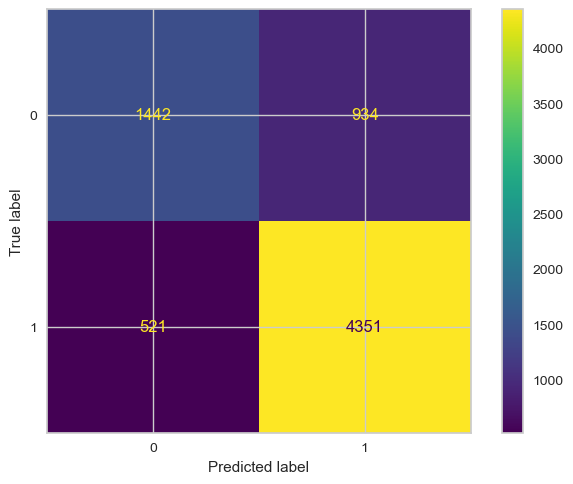

In [21]:
ConfusionMatrixDisplay(confusion_matrix(y_test.values.ravel(), logreg_oob.predict(pipeline_oob_logreg.transform(X_test)))).plot();

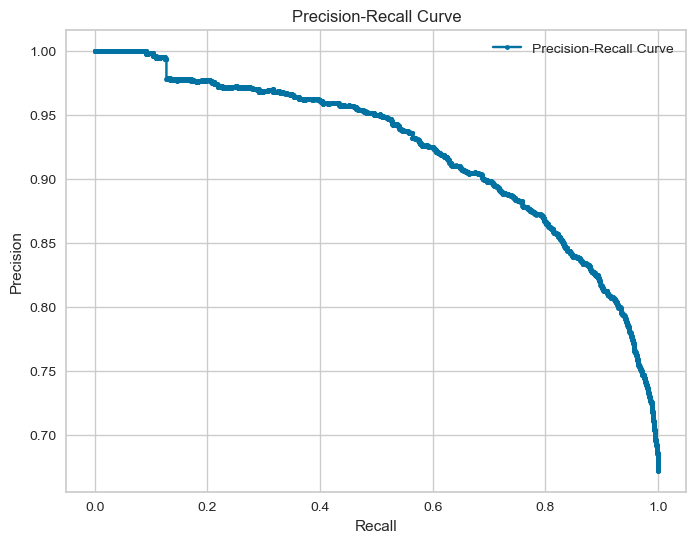

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test.values.ravel(), logreg_oob.predict_proba(pipeline_oob_logreg.transform(X_test))[:,1])
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_test, logreg_oob.predict_proba(pipeline_oob_logreg.transform(X_test))[:,1] > thr) for thr in thresholds]
fbeta_scores = [fbeta_score(y_test, logreg_oob.predict_proba(pipeline_oob_logreg.transform(X_test))[:,1] > thr, beta=1.5) for thr in thresholds]

# Get threshold with highest F1 score
optimal_threshold_f1 = thresholds[np.argmax(f1_scores)]
optimal_threshold_fbeta = thresholds[np.argmax(fbeta_scores)]

print(f'Optimal threshold based on f1: {optimal_threshold_f1}')
print(f'Optimal threshold based on fbeta1.5: {optimal_threshold_fbeta}')

Optimal threshold based on f1: 0.42424242424242425
Optimal threshold based on fbeta1.5: 0.3434343434343435


In [24]:
# Generate predicted probabilities
y_prob = logreg_oob.predict_proba(pipeline_oob_logreg.transform(X_test))[:,1]

# Make class predictions based on the optimal threshold
y_pred_adj_threshold_f1 = (y_prob >= optimal_threshold_f1).astype(int)
y_pred_adj_threshold_fbeta = (y_prob >= optimal_threshold_fbeta).astype(int)

In [25]:
print('Threshold adjusted based on F1...\n')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_adj_threshold_f1)}')
print(f'Precision score: {precision_score(y_test, y_pred_adj_threshold_f1)}')
print(f'Recall score: {recall_score(y_test, y_pred_adj_threshold_f1)}')
print(f'F1 score: {f1_score(y_test, y_pred_adj_threshold_f1)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, logreg_oob.predict_proba(pipeline_oob_logreg.transform(X_test))[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, logreg_oob.predict_proba(pipeline_oob_logreg.transform(X_test))[:, 1])}')

Threshold adjusted based on F1...

Accuracy score: 0.7977373068432672
Precision score: 0.7998239436619718
Recall score: 0.9324712643678161
F1 score: 0.8610689916603488
ROC-AUC score: 0.8579246988909346
Average Precision Score: 0.9218024720997728


In [26]:
print('Threshold adjusted based on FBeta (Recall 1.5x more important than Precision)...\n')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'Precision score: {precision_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'Recall score: {recall_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'F1 score: {f1_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, logreg_oob.predict_proba(pipeline_oob_logreg.transform(X_test))[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, logreg_oob.predict_proba(pipeline_oob_logreg.transform(X_test))[:, 1])}')

Threshold adjusted based on FBeta (Recall 1.5x more important than Precision)...

Accuracy score: 0.785182119205298
Precision score: 0.777964112024149
Recall score: 0.952175697865353
F1 score: 0.8562990309183203
ROC-AUC score: 0.8579246988909346
Average Precision Score: 0.9218024720997728


In [27]:
pipeline_oob_logreg.fit_transform(X_train, y_train.values.ravel())

,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Complementary,market_segment_type_Offline,lead_time,avg_price_per_room,required_car_parking_space,repeated_guest,no_of_special_requests
10409,0.0,0.0,0.0,0.0,0.0,-0.201827,-1.018437,0,0,1
6307,0.0,0.0,0.0,0.0,0.0,0.738327,0.681051,0,0,0
19004,0.0,0.0,0.0,0.0,0.0,-0.155400,-1.025518,0,0,0
9609,0.0,0.0,0.0,0.0,1.0,2.015079,-0.381129,0,0,0
32308,0.0,0.0,0.0,0.0,0.0,-0.445571,0.332302,1,0,1
...,...,...,...,...,...,...,...,...,...,...
18283,0.0,0.0,0.0,0.0,0.0,-0.991092,-0.319168,0,0,0
7308,0.0,0.0,0.0,0.0,0.0,0.668686,-0.253667,0,0,0
22902,0.0,0.0,0.0,0.0,0.0,-0.654494,-0.112043,0,0,1
20224,0.0,0.0,0.0,0.0,0.0,-0.027725,0.918271,0,0,1


In [28]:
coefficients = logreg_oob.coef_[0]
len(coefficients)

10

In [29]:
feature_names = pipeline_oob_logreg.fit_transform(X_train, y_train.values.ravel()).columns
len(feature_names)

10

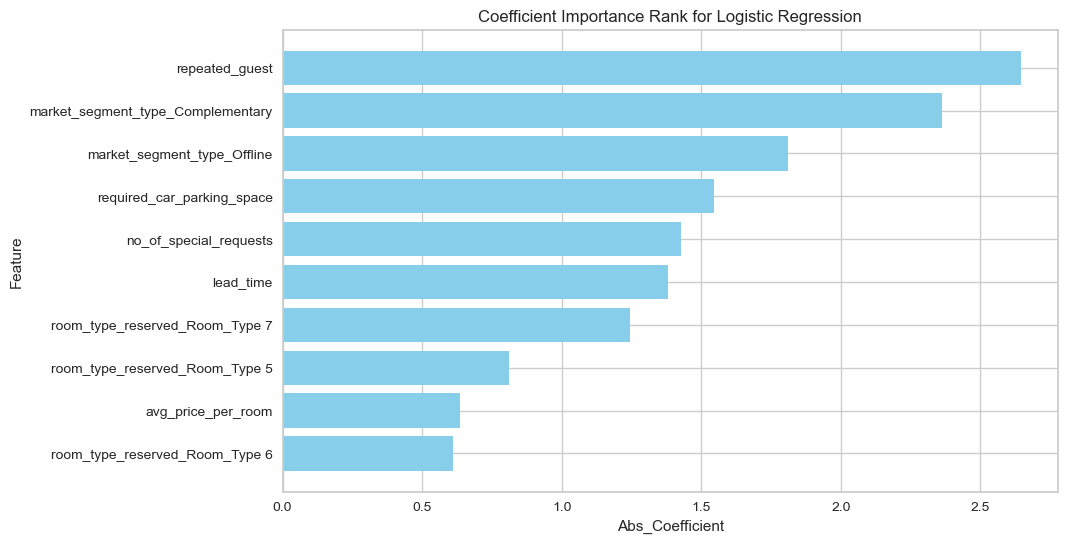

In [30]:
# Create a DataFrame to store the coefficients and names of the features
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute values of the coefficients to determine importance
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
sorted_coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(10)

# Plot the coefficient importance rank using a bar plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_coef_df['Feature'], sorted_coef_df['Abs_Coefficient'], color='skyblue')
plt.xlabel('Abs_Coefficient')
plt.ylabel('Feature')
plt.title('Coefficient Importance Rank for Logistic Regression')
plt.gca().invert_yaxis()  # Invert y-axis to display features with highest coefficient at the top
plt.show()


In [31]:
space = {
    'C': hp.loguniform('C', np.log(0.001), np.log(100)),  # Regularization strength
    'penalty': hp.choice('penalty', ['l1']),  # Penalty type
    # Solvers that support 'l1'
    'solver': hp.choice('solver', [
        ('liblinear', 'l1'),
        ('saga', 'l1'),
    ]),
}

In [32]:
# Objective function for optimization
def objective(params):
    solver, penalty = params['solver']
    
    # Initialize the LogisticRegression model with hyperparameters
    logreg = LogisticRegression(
        C=params['C'],
        penalty=penalty,
        solver=solver,
        max_iter=80000,
        random_state=SEED,
    )

    # Perform cross-validation
    score = cross_val_score(logreg, 
                            X_train_transformed,
                            y_train.values.ravel(),
                            cv=5, 
                            scoring='recall', 
                            n_jobs=-1).mean()
    return {'loss': -score, 'status': STATUS_OK}

In [33]:
trials = Trials()
SEED = 101

# Run the hyperparameter search
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(SEED)
)

100%|██████████| 100/100 [01:02<00:00,  1.61trial/s, best loss: -0.9468906565719404]


In [34]:
# Map the indices to the corresponding solver and penalty values
solver_penalty_mapping = [
    ('liblinear', 'l1'),
    ('saga', 'l1'),
]

In [35]:
best

{'C': 0.0010017545973863631, 'penalty': 0, 'solver': 1}

In [36]:
# Assuming best contains the output from the Hyperopt optimization
penalty = ['l1']
best_params = {
    'C': best['C'],
    'penalty': penalty[best['penalty']],
    'solver': solver_penalty_mapping[best['solver']][0]
}

print(f"Combined hyperparameters: {best_params}")

Combined hyperparameters: {'C': 0.0010017545973863631, 'penalty': 'l1', 'solver': 'saga'}


In [37]:
logreg_tuned = LogisticRegression(**best_params,
                                  n_jobs=-1,
                                  random_state=42,)

logreg_tuned.fit(X_train_transformed,
                 y_train.values.ravel())
y_pred = logreg_tuned.predict(pipeline_oob_logreg.transform(X_test))

In [38]:
precision = precision_score(y_pred, y_test.values.ravel())
recall = recall_score(y_pred, y_test.values.ravel())
f1 = f1_score(y_pred, y_test.values.ravel())
accuracy = accuracy_score(y_pred, y_test.values.ravel())

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'Accuracy: {accuracy:.2f}')

Precision: 0.94
Recall: 0.77
F1-Score: 0.85
Accuracy: 0.77


In [39]:
print(classification_report(label_encoder.inverse_transform(y_test.values.ravel()), label_encoder.inverse_transform(y_pred)))

              precision    recall  f1-score   support

    Canceled       0.78      0.42      0.55      2376
Not_Canceled       0.77      0.94      0.85      4872

    accuracy                           0.77      7248
   macro avg       0.77      0.68      0.70      7248
weighted avg       0.77      0.77      0.75      7248



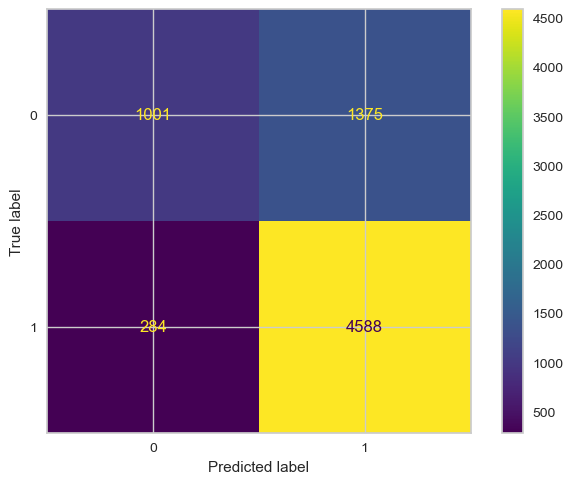

In [40]:
ConfusionMatrixDisplay(confusion_matrix(y_test.values.ravel(), y_pred)).plot();

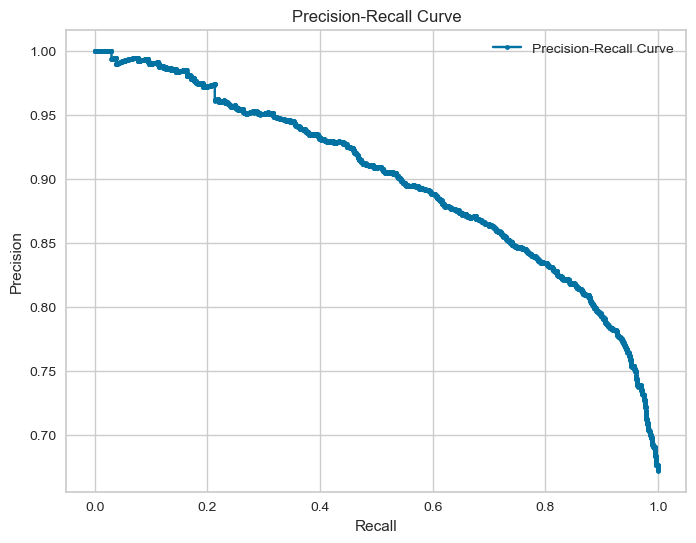

In [41]:
precision, recall, thresholds = precision_recall_curve(y_test.values.ravel(), logreg_tuned.predict_proba(pipeline_oob_logreg.transform(X_test))[:,1])
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

In [42]:
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_test, logreg_tuned.predict_proba(pipeline_oob_logreg.transform(X_test))[:,1] > thr) for thr in thresholds]
fbeta_scores = [fbeta_score(y_test, logreg_tuned.predict_proba(pipeline_oob_logreg.transform(X_test))[:,1] > thr, beta=1.5) for thr in thresholds]

# Get threshold with highest F1 score
optimal_threshold_f1 = thresholds[np.argmax(f1_scores)]
optimal_threshold_fbeta = thresholds[np.argmax(fbeta_scores)]

print(f'Optimal threshold based on f1: {optimal_threshold_f1}')
print(f'Optimal threshold based on fbeta1.5: {optimal_threshold_fbeta}')

Optimal threshold based on f1: 0.5353535353535354
Optimal threshold based on fbeta1.5: 0.37373737373737376


In [43]:
# Generate predicted probabilities
y_prob = logreg_tuned.predict_proba(pipeline_oob_logreg.transform(X_test))[:,1]

# Make class predictions based on the optimal threshold
y_pred_adj_threshold_f1 = (y_prob >= optimal_threshold_f1).astype(int)
y_pred_adj_threshold_fbeta = (y_prob >= optimal_threshold_fbeta).astype(int)

In [44]:
print('Threshold adjusted based on F1...\n')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_adj_threshold_f1)}')
print(f'Precision score: {precision_score(y_test, y_pred_adj_threshold_f1)}')
print(f'Recall score: {recall_score(y_test, y_pred_adj_threshold_f1)}')
print(f'F1 score: {f1_score(y_test, y_pred_adj_threshold_f1)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, logreg_oob.predict_proba(pipeline_oob_logreg.transform(X_test))[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, logreg_oob.predict_proba(pipeline_oob_logreg.transform(X_test))[:, 1])}')

Threshold adjusted based on F1...

Accuracy score: 0.7759381898454746
Precision score: 0.7813582813582813
Recall score: 0.9256978653530378
F1 score: 0.8474257797820368
ROC-AUC score: 0.8579246988909346
Average Precision Score: 0.9218024720997728


In [45]:
print('Threshold adjusted based on FBeta (Recall 1.5x more important than Precision)...\n')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'Precision score: {precision_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'Recall score: {recall_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'F1 score: {f1_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, logreg_oob.predict_proba(pipeline_oob_logreg.transform(X_test))[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, logreg_oob.predict_proba(pipeline_oob_logreg.transform(X_test))[:, 1])}')

Threshold adjusted based on FBeta (Recall 1.5x more important than Precision)...

Accuracy score: 0.7418598233995585
Precision score: 0.7308106445162282
Recall score: 0.9751642036124795
F1 score: 0.8354875582520004
ROC-AUC score: 0.8579246988909346
Average Precision Score: 0.9218024720997728


# L2 and Elasticnet

In [46]:
space = {
    'C': hp.loguniform('C', np.log(0.001), np.log(100)),  # Regularization strength
    'penalty': hp.choice('penalty', ['l2', 'elasticnet']),  # Penalty type
    # Solvers that support 'l2' and 'elasticnet'
    'solver': hp.choice('solver', [
        ('newton-cg', 'l2'),
        ('lbfgs', 'l2'),
        ('saga', 'elasticnet'),  # 'saga' can be used with 'elasticnet'
    ]),
    'l1_ratio': hp.uniform('l1_ratio', 0, 1)  # Only used with 'elasticnet' penalty and 'saga' solver
}

In [47]:
# Objective function for optimization
def objective(params):
    solver, penalty = params['solver']
    l1_ratio = params['l1_ratio'] if penalty == 'elasticnet' else None
    
    # Initialize the LogisticRegression model with hyperparameters
    logreg = LogisticRegression(
        C=params['C'],
        penalty=penalty,
        solver=solver,
        l1_ratio=l1_ratio,
        max_iter=10000,
        random_state=SEED,
        n_jobs=-1
    )

    # Perform cross-validation
    score = cross_val_score(logreg, 
                            X_train_transformed,
                            y_train.values.ravel(),
                            cv=5, 
                            scoring='recall', 
                            n_jobs=-1).mean()
    return {'loss': -score, 'status': STATUS_OK}

In [48]:
trials = Trials()
SEED = 101

# Run the hyperparameter search
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(SEED)
)

100%|██████████| 100/100 [00:29<00:00,  3.40trial/s, best loss: -0.9408868670997531]


In [49]:
# Map the indices to the corresponding solver and penalty values
solver_penalty_mapping = [
    ('newton-cg', 'l2'),
    ('lbfgs', 'l2'),
    ('saga', 'elasticnet')
]

In [50]:
best

{'C': 0.0010021011882319563,
 'l1_ratio': 0.5356226283765249,
 'penalty': 0,
 'solver': 2}

In [51]:
# Assuming best contains the output from the Hyperopt optimization
penalty = ['l2', 'elasticnet']
best_params = {
    'C': best['C'],
    'penalty': penalty[best['penalty']],
    'solver': solver_penalty_mapping[best['solver']][0]
}

# Include l1_ratio only if the best penalty is 'elasticnet'
if best_params['penalty'] == 'elasticnet':
    best_params['l1_ratio'] = best['l1_ratio']

print(f"Combined hyperparameters: {best_params}")

Combined hyperparameters: {'C': 0.0010021011882319563, 'penalty': 'l2', 'solver': 'saga'}


In [52]:
logreg_tuned = LogisticRegression(**best_params,
                                  n_jobs=-1,
                                  random_state=42,)

logreg_tuned.fit(X_train_transformed,
                 y_train.values.ravel())
y_pred = logreg_tuned.predict(pipeline_oob_logreg.transform(X_test))

In [53]:
precision = precision_score(y_pred, y_test.values.ravel())
recall = recall_score(y_pred, y_test.values.ravel())
f1 = f1_score(y_pred, y_test.values.ravel())
accuracy = accuracy_score(y_pred, y_test.values.ravel())

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'Accuracy: {accuracy:.2f}')

Precision: 0.93
Recall: 0.79
F1-Score: 0.85
Accuracy: 0.79


In [54]:
print(classification_report(label_encoder.inverse_transform(y_test.values.ravel()), label_encoder.inverse_transform(y_pred)))

              precision    recall  f1-score   support

    Canceled       0.78      0.49      0.60      2376
Not_Canceled       0.79      0.93      0.85      4872

    accuracy                           0.79      7248
   macro avg       0.78      0.71      0.73      7248
weighted avg       0.79      0.79      0.77      7248



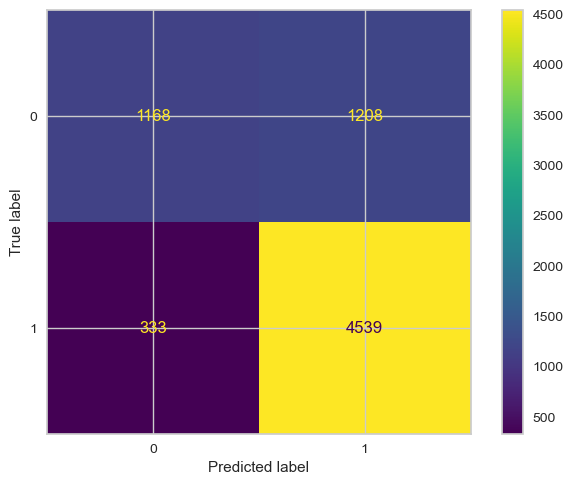

In [55]:
ConfusionMatrixDisplay(confusion_matrix(y_test.values.ravel(), y_pred)).plot();

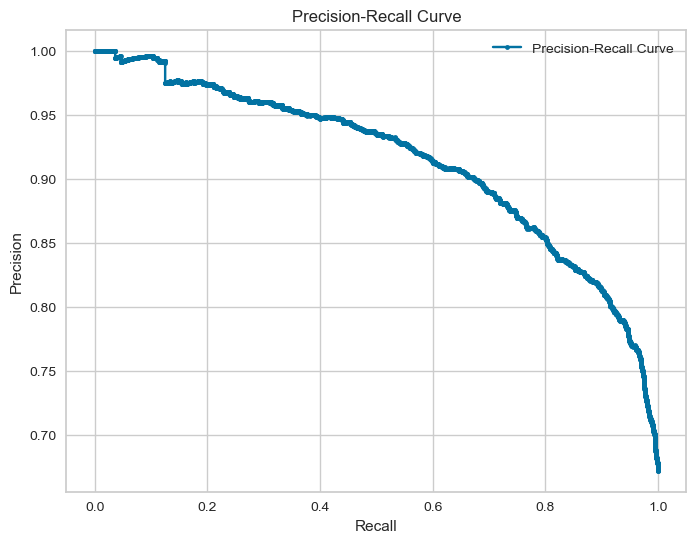

In [56]:
precision, recall, thresholds = precision_recall_curve(y_test.values.ravel(), logreg_tuned.predict_proba(pipeline_oob_logreg.transform(X_test))[:,1])
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

In [57]:
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_test, logreg_tuned.predict_proba(pipeline_oob_logreg.transform(X_test))[:,1] > thr) for thr in thresholds]
fbeta_scores = [fbeta_score(y_test, logreg_tuned.predict_proba(pipeline_oob_logreg.transform(X_test))[:,1] > thr, beta=1.5) for thr in thresholds]

# Get threshold with highest F1 score
optimal_threshold_f1 = thresholds[np.argmax(f1_scores)]
optimal_threshold_fbeta = thresholds[np.argmax(fbeta_scores)]

print(f'Optimal threshold based on f1: {optimal_threshold_f1}')
print(f'Optimal threshold based on fbeta1.5: {optimal_threshold_fbeta}')

Optimal threshold based on f1: 0.494949494949495
Optimal threshold based on fbeta1.5: 0.4141414141414142


In [58]:
# Generate predicted probabilities
y_prob = logreg_tuned.predict_proba(pipeline_oob_logreg.transform(X_test))[:,1]

# Make class predictions based on the optimal threshold
y_pred_adj_threshold_f1 = (y_prob >= optimal_threshold_f1).astype(int)
y_pred_adj_threshold_fbeta = (y_prob >= optimal_threshold_fbeta).astype(int)

In [59]:
print('Threshold adjusted based on F1...\n')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_adj_threshold_f1)}')
print(f'Precision score: {precision_score(y_test, y_pred_adj_threshold_f1)}')
print(f'Recall score: {recall_score(y_test, y_pred_adj_threshold_f1)}')
print(f'F1 score: {f1_score(y_test, y_pred_adj_threshold_f1)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, logreg_oob.predict_proba(pipeline_oob_logreg.transform(X_test))[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, logreg_oob.predict_proba(pipeline_oob_logreg.transform(X_test))[:, 1])}')

Threshold adjusted based on F1...

Accuracy score: 0.7897350993377483
Precision score: 0.7886206896551724
Recall score: 0.9388341543513957
F1 score: 0.8571964017991005
ROC-AUC score: 0.8579246988909346
Average Precision Score: 0.9218024720997728


In [60]:
print('Threshold adjusted based on FBeta (Recall 1.5x more important than Precision)...\n')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'Precision score: {precision_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'Recall score: {recall_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'F1 score: {f1_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, logreg_oob.predict_proba(pipeline_oob_logreg.transform(X_test))[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, logreg_oob.predict_proba(pipeline_oob_logreg.transform(X_test))[:, 1])}')

Threshold adjusted based on FBeta (Recall 1.5x more important than Precision)...

Accuracy score: 0.7722130242825607
Precision score: 0.7590477722374136
Recall score: 0.9685960591133005
F1 score: 0.8511137162954279
ROC-AUC score: 0.8579246988909346
Average Precision Score: 0.9218024720997728
